In [32]:
import tensorflow as tf
import pandas as pd
import os
import tensorflow_addons as tfa
import cv2
import glob

from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
from tensorflow.python.ops.numpy_ops import np_config
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
#from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label



from src.swin_transformer.model import *
from src.swin_transformer.helper import *
from src.swin_transformer.patches import *
from src.swin_transformer.window_attn import *
from src.data_prepare import preprocess_data
from src.utils import *


/tmp/ipykernel_500388/934890785.py:18: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [45]:
K.set_image_data_format('channels_first')

In [46]:
#K.set_image_dim_ordering('th')
np_config.enable_numpy_behavior()

# Data errors

In [3]:
annot_df = {'img_name' : [],'classes' : [],'x' : [],'y' : [],'width' : [],'height' : []}
sample = {'image' : [],'bbox' : [],'label' : []}
empty_list = []
for idx,i in tqdm(enumerate(os.listdir('kaggle/train/labels/'))):
    ## Empty Labels
    try:
        tmp_df = pd.read_csv(f'kaggle/train/labels/{i}',header=None)
        for j in tmp_df[0].values:
            annot_df['img_name'].append(f'kaggle/train/images/{i.split(".")[0]}.png')
            #sample['image'] = Image.open(f'kaggle/train/images/{i.split(".")[0]}.png').convert('RGB')
            annot_df['classes'].append(j.split()[0])
            annot_df['x'].append(j.split()[1])
            annot_df['y'].append(j.split()[2])
            annot_df['width'].append(j.split()[3])
            annot_df['height'].append(j.split()[4])
            ###
            sample['label'].append(j.split()[0])
            sample['bbox'].append(j.split()[1])
            sample['bbox'].append(j.split()[2])
            sample['bbox'].append(j.split()[3])
            sample['bbox'].append(j.split()[4])
    except pd.errors.EmptyDataError:
        empty_list.append(i)
        continue

2474it [00:01, 1581.73it/s]


In [4]:
empty_list

['07081.txt',
 '02528.txt',
 '04966.txt',
 '06229.txt',
 '04285.txt',
 '03798.txt',
 '02448.txt']

In [5]:
df = pd.DataFrame.from_dict(annot_df)


## Plot Images

In [6]:
def plot_image(value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Load all objects
     
    tmp_df = df.query(f"img_name == '{annot_df['img_name'][value]}'")

    for idx, rows in tmp_df.iterrows():

        # Load xy, width and height
        x = (float(rows['x']) - float(rows['width']) * 0.5) * image.size[0]
        y = (float(rows['y']) - float(rows['height']) * 0.5) * image.size[1]
        width = float(rows['width']) * image.size[0]
        height = float(rows['height']) * image.size[1]
        
        # Dsiplay the image
        ax.imshow(image)

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.show()

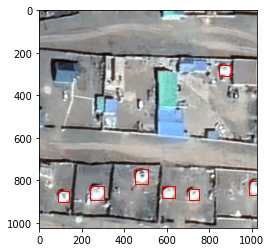

In [7]:
plot_image(0)

In [8]:
def plot_resized_image(resize_size:tuple,value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Resize image
    image = tf.image.resize_with_pad(image,resize_size[0],resize_size[1])
    image = image.astype(np.uint8)

    # Load all objects
     
    tmp_df = df.query(f"img_name == '{annot_df['img_name'][value]}'")

    for idx, rows in tmp_df.iterrows():

        # Load xy, width and height
        x = (float(rows['x']) - float(rows['width']) * 0.5) * resize_size[0]
        y = (float(rows['y']) - float(rows['height']) * 0.5) * resize_size[1]
        width = float(rows['width']) * resize_size[0]
        height = float(rows['height']) * resize_size[1]
        
        # Dsiplay the image
        ax.imshow(image)

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.show()

2022-05-31 00:39:12.269931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 00:39:12.270739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 00:39:12.274882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 00:39:12.275650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 00:39:12.276390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

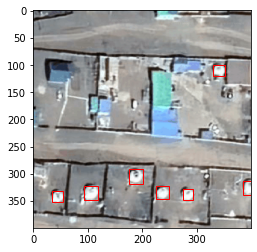

In [9]:
plot_resized_image((400,400),0)

In [10]:
df

,img_name,classes,x,y,width,height
0,kaggle/train/images/04320.png,0,0.981836,0.815967,0.036328,0.067676
1,kaggle/train/images/04320.png,0,0.593945,0.836572,0.059375,0.056152
2,kaggle/train/images/04320.png,0,0.470215,0.762305,0.062695,0.069336
3,kaggle/train/images/04320.png,0,0.264795,0.839844,0.064355,0.066016
4,kaggle/train/images/04320.png,0,0.111328,0.854736,0.051172,0.052832
...,...,...,...,...,...,...
23450,kaggle/train/images/01431.png,0,0.901563,0.052295,0.129297,0.104590
23451,kaggle/train/images/01431.png,0,0.543652,0.027588,0.131445,0.055176
23452,kaggle/train/images/00666.png,0,0.848437,0.108545,0.137109,0.137012
23453,kaggle/train/images/05487.png,0,0.958496,0.692871,0.083008,0.102539


In [11]:
def convert_bbox(x):
    img = Image.open(x['img_name'])
    #sizes = img.size
    # Load xy, width and height
    x_mod = (float(x['x']) - float(x['width']) * 0.5) * img.size[0]
    y_mod = (float(x['y']) - float(x['height']) * 0.5) * img.size[1]
    width_mod = float(x['width']) * img.size[0]
    height_mod = float(x['height']) * img.size[1]
    return pd.Series([x_mod,y_mod,width_mod,height_mod],index=['x_mod','y_mod','width_mod','height_mod'])

In [12]:
df[['x_mod','y_mod','width_mod','height_mod']] = df.apply(lambda x: convert_bbox(x),axis=1)
df[['x_mod','y_mod','width_mod','height_mod']] = df[['x_mod','y_mod','width_mod','height_mod']].astype(int)

In [13]:
df

,img_name,classes,x,y,width,height,x_mod,y_mod,width_mod,height_mod
0,kaggle/train/images/04320.png,0,0.981836,0.815967,0.036328,0.067676,986,800,37,69
1,kaggle/train/images/04320.png,0,0.593945,0.836572,0.059375,0.056152,577,827,60,57
2,kaggle/train/images/04320.png,0,0.470215,0.762305,0.062695,0.069336,449,745,64,71
3,kaggle/train/images/04320.png,0,0.264795,0.839844,0.064355,0.066016,238,826,65,67
4,kaggle/train/images/04320.png,0,0.111328,0.854736,0.051172,0.052832,87,848,52,54
...,...,...,...,...,...,...,...,...,...,...
23450,kaggle/train/images/01431.png,0,0.901563,0.052295,0.129297,0.104590,857,0,132,107
23451,kaggle/train/images/01431.png,0,0.543652,0.027588,0.131445,0.055176,489,0,134,56
23452,kaggle/train/images/00666.png,0,0.848437,0.108545,0.137109,0.137012,798,40,140,140
23453,kaggle/train/images/05487.png,0,0.958496,0.692871,0.083008,0.102539,938,656,85,104


(-69.1875, 655.4375, 630.025, -0.5)

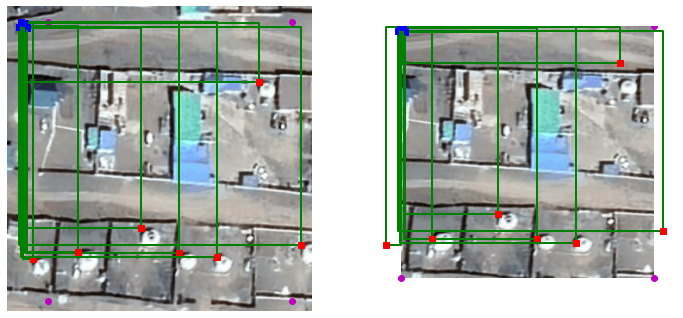

In [14]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,1,augmentation=False,trans_range=0,scale_range=0)
img_mask =get_mask_seg(img,bb_boxes)

tr_x1 = 80
tr_y1 = 30
tr_x2 = 40
tr_y2 = 20



p1 = (tr_x1,tr_y1)
p2 = (img.shape[1]-tr_x2,tr_y1)

p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
p4 = (tr_x1,img.shape[0]-tr_y2)

pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],[0,img.shape[0]] ]
                   )

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
dst = np.array(dst,dtype=np.uint8)


plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.plot(p1[0],p1[1],'mo')
plt.plot(p2[0],p2[1],'mo')
plt.plot(p3[0],p3[1],'mo')
plt.plot(p4[0],p4[1],'mo')
for i in range(len(bb_boxes)):
    plot_bbox(bb_boxes,i,'g')
    
    bb_box_i = [bb_boxes.iloc[i]['x_mod'],bb_boxes.iloc[i]['y_mod'],
                bb_boxes.iloc[i]['width_mod'],bb_boxes.iloc[i]['height_mod']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dst)
bb_boxes1 = bb_boxes.copy(deep=True)
bb_boxes1['x_mod'] = (bb_boxes['x_mod'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['y_mod'] = (bb_boxes['y_mod'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['width_mod'] = (bb_boxes['width_mod'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
bb_boxes1['height_mod'] = (bb_boxes['height_mod'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
plt.plot(0,0,'mo')
plt.plot(img.shape[1],0,'mo')
plt.plot(img.shape[1],img.shape[0],'mo')
plt.plot(0,img.shape[0],'mo')
plot_im_bbox(dst,bb_boxes1)

plt.axis('off')

(-0.5, 599.5, 599.5, -0.5)

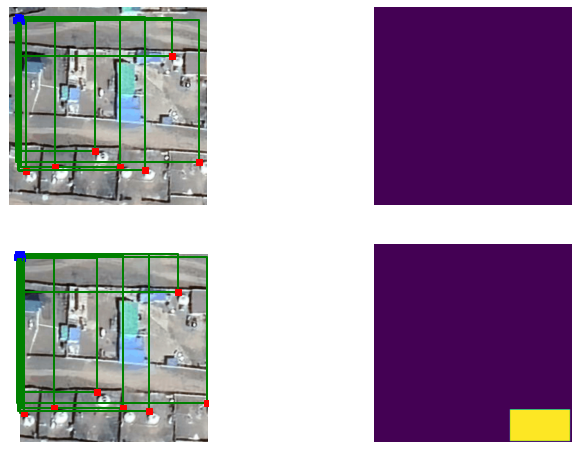

In [17]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
dst,bb_boxes1 = stretch_image(img,bb_boxes,100)

plt.imshow(dst)

plot_im_bbox(dst,bb_boxes1)

plt.subplot(2,2,4)
img_mask2 =get_mask_seg(dst,bb_boxes1)
plt.imshow(img_mask2[:,:,0])
plt.axis('off')

(-0.5, 599.5, 599.5, -0.5)

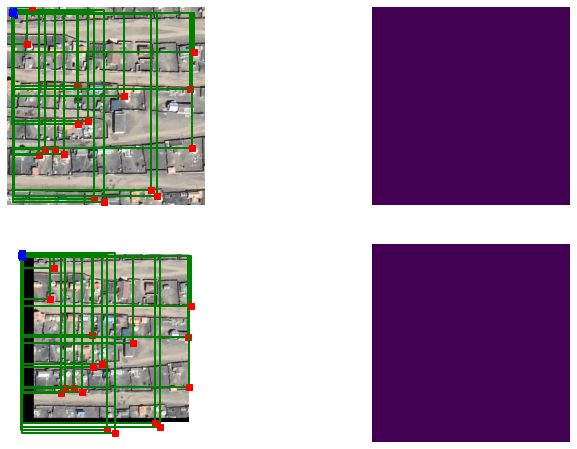

In [19]:
### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,200,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,100)

plt.imshow(img_trans)

plot_im_bbox(img_trans,bb_boxes1)
img_mask2 =get_mask_seg(img_trans,bb_boxes1)

plt.subplot(2,2,4)
plt.imshow(img_mask2[:,:,0])
plt.axis('off')

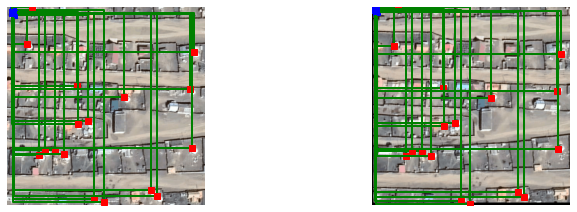

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)
plt.subplot(2,2,2)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,50)
plt.imshow(img_trans)
plot_im_bbox(img_trans,bb_boxes1)

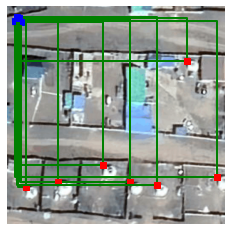

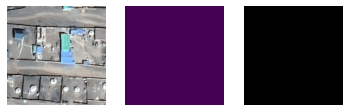

In [22]:
#### Put all the augmentations in 1 function with a flag for augmentation


name_str,img,bb_boxes = get_image_name(df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)


plt.figure(figsize=(6,4))
plt.imshow(img)
plot_im_bbox(img,bb_boxes)
plt.show()

plot_im_mask(img,img_mask)

## Prepare data

In [79]:
#### Training generator, generates augmented images
def generate_train_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, 960, 960, 3))
    batch_masks = np.zeros((batch_size, 960, 960, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data)-2000)
            name_str,img,bb_boxes = get_image_name(df,i_line,
                                                   size=(960, 960),
                                                  augmentation=True,
                                                   trans_range=50,
                                                   scale_range=50
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks
        
#### Testing generator, generates augmented images
def generate_test_batch(data,batch_size = 32):
    batch_images = np.zeros((batch_size, 960, 960, 3))
    batch_masks = np.zeros((batch_size, 960, 960, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(2000)
            i_line = i_line+len(data)-2000
            name_str,img,bb_boxes = get_image_name(df,i_line,
                                                   size=(960, 960),
                                                  augmentation=False,
                                                   trans_range=0,
                                                   scale_range=0
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks

In [80]:
##### Testing the generator


training_gen = generate_train_batch(df,10)

In [81]:
batch_img,batch_mask = next(training_gen)

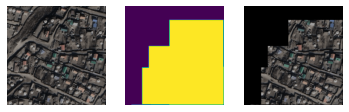

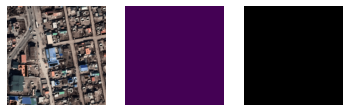

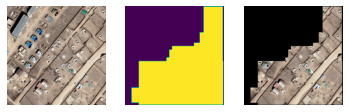

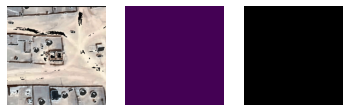

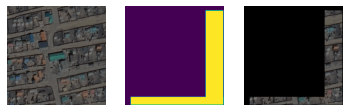

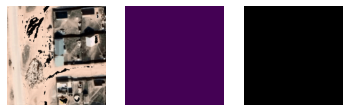

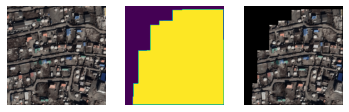

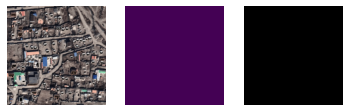

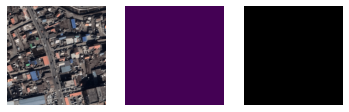

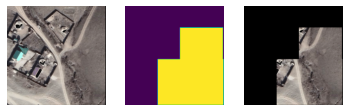

In [82]:
### Plotting generator output
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask))
    plt.axis('off')
    plt.show()

## Prepare IOU Loss

In [83]:
### IOU or dice coeff calculation

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [87]:
from keras.layers import *

def unet(input_size = (960,960,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.3)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    #model.compile(optimizer = tf.keras.optmizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()
    return model

In [88]:
K.set_image_data_format('channels_last')

In [90]:
### Generator 

training_gen = generate_train_batch(df,1)
smooth = 1.
model = unet()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), 
              loss=IOU_calc_loss, metrics=[IOU_calc])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [93]:
history = model.fit(training_gen,
                              steps_per_epoch=1000, 
                              epochs=5)

/tmp/ipykernel_500388/1771130472.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_gen,


Epoch 1/5


2022-05-31 01:18:51.139975: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400


1000/1000 [==============================] - 219s 211ms/step - loss: -0.3111 - IOU_calc: 0.3111
Epoch 2/5
1000/1000 [==============================] - 212s 212ms/step - loss: -0.2954 - IOU_calc: 0.2954
Epoch 3/5
1000/1000 [==============================] - 212s 212ms/step - loss: -0.2788 - IOU_calc: 0.2788
Epoch 4/5
1000/1000 [==============================] - 212s 212ms/step - loss: -0.2997 - IOU_calc: 0.2997
Epoch 5/5
1000/1000 [==============================] - 211s 211ms/step - loss: -0.2892 - IOU_calc: 0.2892


In [23]:
input_shape = (200, 200, 3)
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 4  # Attention heads
embed_dim = 256  # Embedding dimension
num_mlp = 128  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 200  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 64
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [24]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(4, activation="sigmoid")(x)

In [25]:
model = keras.Model(input, output)

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 random_crop_1 (RandomCrop)  (None, 200, 200, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 200, 200, 3)       0         
                                                                 
 patch_extract_1 (PatchExtra  (None, 10000, 12)        0         
 ct)                                                             
                                                                 
 patch_embedding_1 (PatchEmb  (None, 10000, 256)       2563328   
 edding)                                                         
                                                                 
 swin_transformer_2 (SwinTra  (None, 10000, 256)       3301

In [27]:
model.compile(
    loss=['mse'],
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
'mse',
    ],
)

In [28]:
model.fit(images,bbox,64,40)

2022-05-26 10:43:22.794049: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11258400000 exceeds 10% of free system memory.
2022-05-26 10:43:27.289292: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11258400000 exceeds 10% of free system memory.


Epoch 1/40


2022-05-26 10:43:33.079074: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-05-26 10:43:43.182843: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 625.00MiB (rounded to 655360000)requested by op model_1/swin_transformer_2/sequential_2/dropout_8/dropout/Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-05-26 10:43:43.182908: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-05-26 10:43:43.182922: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 110, Chunks in use: 108. 27.5KiB allocated for chunks. 27.0KiB in use in bin. 2.9KiB client-requested in use in bin.
2022-05-26 10:43:43.182932: 

ResourceExhaustedError:  failed to allocate memory
	 [[node model_1/swin_transformer_2/sequential_2/dropout_8/dropout/Mul
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/core/dropout.py:105)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2869256]

Errors may have originated from an input operation.
Input Source operations connected to node model_1/swin_transformer_2/sequential_2/dropout_8/dropout/Mul:
In[0] model_1/swin_transformer_2/sequential_2/dense_15/BiasAdd (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/core/dense.py:210)	
In[1] model_1/swin_transformer_2/sequential_2/dropout_8/dropout/Const:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 972, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 493, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 724, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
>>>     res = shell.run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3397, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_828/2569246027.py", line 1, in <cell line: 1>
>>>     model.fit(images,bbox,64,40)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/workspaces/Object-Detection-BB/src/swin_transformer/model.py", line 128, in call
>>>     x = self.mlp(x)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/core/dropout.py", line 111, in call
>>>     output = control_flow_util.smart_cond(training, dropped_inputs,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
>>>     return tf.__internal__.smart_cond.smart_cond(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/core/dropout.py", line 105, in dropped_inputs
>>>     return tf.nn.dropout(
>>> 